In [1]:
%load_ext autoreload
%autoreload 2

from wb_api_wraper import *

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from IPython.display import display, HTML

import matplotlib.pyplot as plt 
%matplotlib inline


In [2]:
#Pandas display options
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.width', 200)
pd.set_option('display.precision', 2)
pd.set_option('display.max_rows', 200)

In [3]:
#Options for plots
font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 12}

plt.rc('font', **font)
plt.rcParams["legend.fancybox"]=True
plt.rcParams["savefig.dpi"]=90

plot_options = dict(alpha=0.5,clip_on=False)

def format_fig(ax):
    ax.set_xlim(0)
    ax.set_ylim(0)

In [4]:
#Searching the WB API database

search_wb("GDP");
search_wb("emissions");

#Data

In [5]:
gni = True #use GDP per capita if if false

In [6]:
all_ghg = False  #use only CO2 if false, all GHG if true

###Pop and gdp

In [7]:
#gdp_pc_ppp  = get_wb("NY.GNP.PCAP.PP.CD") if gni else get_wb("NY.GDP.PCAP.PP.CD")#GDP per capita, PPP (constant 2011 international $)
gdp = get_wb("NY.GDP.MKTP.PP.KD")#GGDP, PPP (constant 2011 international $)
pop = get_wb("SP.POP.TOTL") #population

gdp_pc_ppp=gdp/pop

In [8]:
#(pop*gdp_pc_ppp)/gdp #sanity check: pop, gdp and gdp_pc are consistent, notably in recent years

###Emissions

In [9]:
if all_ghg:
    other_ghg_tot = (get_wb("EN.ATM.METH.KT.CE")  #total methane
                      +get_wb("EN.ATM.NOXE.KT.CE")  #total nitrous o
                      +get_wb("EN.ATM.GHGO.KT.CE") #total other
                      )*1000 #emissions in tons


    for c in range(2000,2011):
        if str(c) not in other_ghg_tot.columns:
            other_ghg_tot[str(c)]=np.nan


    from scipy.interpolate import interp1d

    other_ghg_tot=other_ghg_tot.sort_index(axis=1).interpolate(axis=1)
    other_ghg_tot["2011"]=2*other_ghg_tot["2010"]-other_ghg_tot["2009"]

    emis_tot=(emis_tot+other_ghg_tot).fillna(emis_tot)
    
    emis_intens = emis_tot /gdp 

else:
    #emis_intens = get_wb_mrv("EN.ATM.CO2E.KD.GD","emis_intens") /1000 #CO2 emissions (data in kg per 2005 US$ of GDP), converted in tons per ...
    #emis_intens = get_wb("EN.ATM.CO2E.PP.GD.KD")/1000 #CO2 emissions in tons, from  #CO2 emissions (kg per 2011 PPP $ of GDP)
    emis_tot = get_wb("EN.ATM.CO2E.KT")*1000 #emissions in tons
    #Both series end in 2011
    
emis_intens = emis_tot /gdp 
emis_pc = emis_tot/pop

In [10]:
#(emis_intens*gdp/emis_tot) #sanity check: these amtch exactly (intens must be computed this way)

###Dataframe

In [11]:
#Income gorups for countries and HIPC status
groups = pd.read_csv("counry_income_groups.csv",header =4,index_col=2).replace({"ROM":"ROU","ZAR":"COD"})  #they used old iso3 country for Zair (Congo) and Romania
groups.dropna(axis=0,how="all",inplace=True);

In [12]:
df=pd.DataFrame()
df["emis_intens"]=emis_intens.stack()
df["gdp_pc"] = gdp_pc_ppp.stack()
df["pop"] = pop.stack()
df["emis_tot"] = emis_tot.stack()

emis_pc = emis_tot.stack()/pop.stack()
df["emis_pc"]= emis_pc

df= df.ix[groups.index.values] #keeps only actula countries (no macro regions or groups of countries)

data_all = df.reset_index()

#emission intensity last year
emis_intens_peryear=data_all.set_index(["country","year"]).emis_intens.unstack()
emis_intens_last_year =emis_intens_peryear[0:-1]
emis_intens_last_year.columns=emis_intens_last_year.columns.map(lambda x: str(1+eval(x)))
emis_intens_last_year.columns.name="year"
emis_intens_last_year.stack().reset_index()

data_all=pd.merge(data_all,emis_intens_last_year.stack().reset_index(),on=["country","year"],how="outer").dropna().rename(columns={0:"emis_intens_last_year"})


#income bins
bins = [0]+ data_all.gdp_pc.quantile([.2,.4,.6,.8,1]).tolist()
bins = [0]+ data_all.gdp_pc.quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,1]).tolist()
bins[-1]=1e7 #"makes sure the last bins covers future incomes"
print(bins)

x=pd.cut(data_all.gdp_pc,bins);
x.name="inc_bins"

data_all = pd.concat([data_all,x],axis=1)


#dummy for 2011 to center the rpediciton there
data_all["dummy2011"]=(data_all["year"]=="2011")+0


[0, 1436.6663226782739, 2402.8887684883011, 4133.1475781432082, 6354.2476397140972, 9292.5645757165403, 12494.067035906739, 18018.28342844154, 28177.540230618019, 41640.866756502095, 10000000.0]


In [13]:
#Current emissions
emis_ref = data_all.dropna().query("year=='2011'").emis_tot.sum()
print("Global CO2 emissions in the sample: {emis:0.0f} GtCO2".format(emis=emis_ref*1e-9)+("eq" if all_ghg else ""))

Global CO2 emissions in the sample: 32 GtCO2


In [14]:
emissions_RCP_2030 = 7.157*44/12 * 1e9
emissions_RCP_2030/emis_ref

0.8188079355022005

In [15]:
emissions_RCP_2050 = 3.186*44/12 * 1e9
emissions_RCP_2050/emis_ref

0.36449938277350996

In [18]:
#What ending povety means
target_gdp_pc = 4000

#Emissions in LICs today
data2011= data_all.query("year=='2011'").copy()
LICs = data2011.ix[data2011.gdp_pc<target_gdp_pc].index
print("emissions in the LICs in 2011: {x:.2%}".format(x=data2011.ix[LICs].emis_tot.sum()/emis_ref))

#Countries with low income
country_lics = data2011.ix[LICs].country.tolist()
print(country_lics)
data2011.ix[LICs].country.to_csv( "countries_below_4000.txt", index=False, header="country")
len(LICs)

emissions in the LICs in 2011: 0.66%
['Afghanistan', 'Bangladesh', 'Benin', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Djibouti', 'Eritrea', 'Ethiopia', 'Gambia, The', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Kenya', 'Kiribati', 'Kyrgyz Republic', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Marshall Islands', 'Mauritania', 'Micronesia, Fed. Sts.', 'Mozambique', 'Nepal', 'Niger', 'Papua New Guinea', 'Rwanda', 'Senegal', 'Sierra Leone', 'Solomon Islands', 'Tajikistan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Vanuatu', 'Yemen, Rep.', 'Zambia']


46

##Lorenz curve

In [515]:
dflor = data_all.query("year=='2011'")[["country","pop","gdp_pc","emis_tot"]].sort("gdp_pc")
dflor["cum_emis"]=dflor.emis_tot.cumsum()
dflor["cum_pop"]=dflor["pop"].cumsum()
#dflor.plot(x="cum_pop",y="cum_emis")

dflor.head(5)

,country,pop,gdp_pc,emis_tot,cum_emis,cum_pop
455,"Congo, Dem. Rep.",63931512,657.3,3424978,3424978,6.4e+07
1130,Liberia,4079697,729.0,891081,4316059,6.8e+07
322,Burundi,9540362,731.3,209019,4525078,7.8e+07
1209,Malawi,15457531,747.3,1206443,5731521,9.3e+07
1443,Niger,16511462,828.5,1422796,7154317,1.1e+08


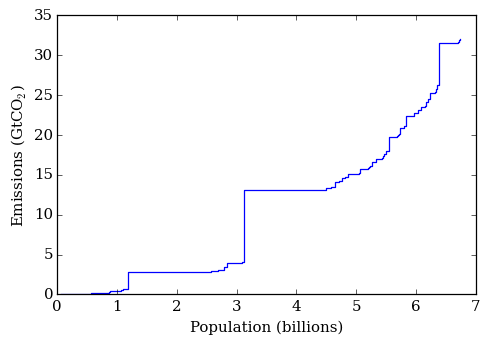

In [516]:
plt.step(dflor.cum_pop/1e9, dflor.cum_emis/1e9)
plt.xlabel("Population (billions)")
plt.ylabel('Emissions (GtCO$_2$)')
plt.savefig("lorentz_2011.png")


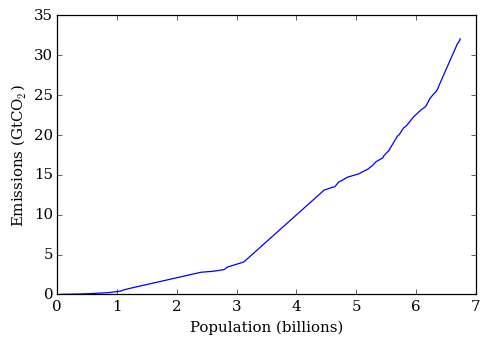

In [517]:
plt.xlabel("Population (billions)")
plt.ylabel('Emissions (GtCO$_2$)')
plt.plot(dflor.cum_pop/1e9, dflor.cum_emis/1e9)
plt.savefig("lorentz_2011_lisse.png")

###Population and GDP from SSP

In [518]:
pop_proj_2050 =1e6* pd.read_csv("population_ssp.csv", index_col="country", dtype={"scenario":str}).query("scenario=='SSP5'")["2050"].sort_index()
pop_proj_2050.name="pop"

In [519]:
pop_proj_2030 =1e6* pd.read_csv("population_ssp.csv", index_col="country", dtype={"scenario":str}).query("scenario=='SSP5'")["2030"]
pop_proj_2030.name="pop"

In [520]:
gdp_pc_proj_2050 = pd.read_csv("gdp_ssp.csv", index_col="country", dtype={"scenario":str}).query("scenario=='SSP5'")["2050"]/ pop_proj_2050  *1e9  #GDP per capita in $
gdp_pc_proj_2050.name="gdp_pc"

In [521]:
gdp_pc_proj_2030 = pd.read_csv("gdp_ssp.csv", index_col="country", dtype={"scenario":str}).query("scenario=='SSP5'")["2030"]/ pop_proj_2030  *1e9  #GDP per capita in $
gdp_pc_proj_2030.name="gdp_pc"

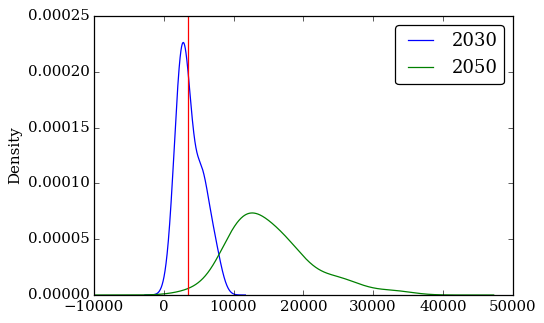

In [522]:
gdp_pc_proj_2030[country_lics].plot(kind="kde")
gdp_pc_proj_2050[country_lics].plot(kind="kde")
plt.legend(["2030","2050"])
plt.plot([3500, 3500],[0, 25*1e-5])

In the SSP5, many countries that are poor today remain poor in 2030

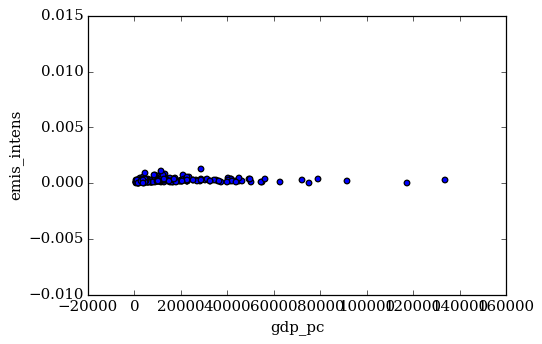

In [523]:
data_all.query("year=='2011'").plot(y="emis_intens",x="gdp_pc",kind="scatter")

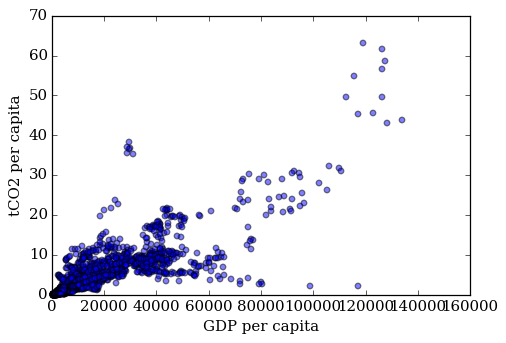

In [524]:
fig, ax = plt.subplots(1,1)
ax.scatter(data_all.gdp_pc,data_all.emis_pc,**plot_options)
ax.set_xlabel('GDP per capita')
ax.set_ylabel('tCO2 per capita')
format_fig(ax)

In [525]:
bins

[0,
 1436.6663226782739,
 2402.8887684883011,
 4133.1475781432082,
 6354.2476397140972,
 9292.5645757165403,
 12494.067035906739,
 18018.28342844154,
 28177.540230618019,
 41640.866756502095,
 10000000.0]

(0.0, 0.002)

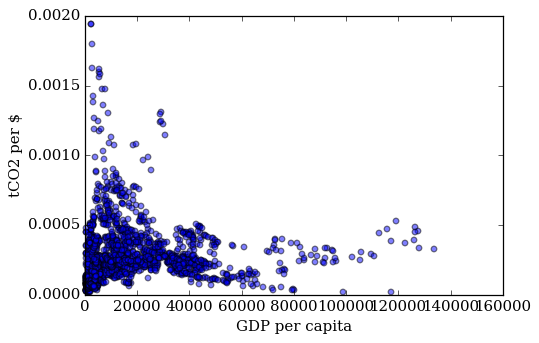

In [526]:
fig, ax = plt.subplots(1,1)
ax.scatter(data_all.gdp_pc,data_all.emis_intens,**plot_options)
ax.set_xlabel('GDP per capita')
ax.set_ylabel('tCO2 per $')
format_fig(ax)
ax.set_ylim(ymax=0.002)

#Simulations

#Fitting different models

In [527]:
def project_emissions(formula, data):
    print("\n"+formula)
    
    data2011= data.query("year=='2011'").copy()
    LICs = data2011.ix[data2011.gdp_pc.clip(lower=target_gdp_pc)==target_gdp_pc].index
    
    mod = smf.ols(formula, data).fit()
    mod_weighted = smf.wls(formula, data, weights = data["pop"]).fit()

    
    print("\n========= Predicted 2011")
    simulation = data2011
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=emis_tot.sum()/emis_ref-1,
            y=emis_tot_weighted.sum()/emis_ref-1)
         )
    
    e_ref = emis_tot
    e_w_ref = emis_tot_weighted
    
    
    def report(emis_tot,emis_tot_weighted):
        print("Emissions increased by {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=(emis_tot).sum()/emis_ref,
            y=(emis_tot_weighted).sum()/emis_ref)
         )
    
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    print("\n========= Liting Income")
    simulation = data2011.assign(gdp_pc = data.gdp_pc.clip(lower=target_gdp_pc), inc_bins = pd.cut(data2011.gdp_pc,bins))
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    print('\n==========Liting Income and population')
    simulation = data2011.assign(gdp_pc = data.gdp_pc.clip(lower=target_gdp_pc),inc_bins = pd.cut(data2011.gdp_pc,bins) )
    simulation.ix[LICs,"pop"] = pop_proj_2030.ix[data.ix[LICs].country].values
    
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    print('\n==========new POPULATION, old income')
    simulation = data2011
    simulation.ix[LICs,"pop"] = pop_proj_2030.ix[data.ix[LICs].country].values
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]

    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    #simulation["emis_tot_weighted"] =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    
    #simulation["emis_intens_pred"]
    #simulation["emis_pc"] = simulation["emis_intens_pred"]
    #simulation["emis_tot"] = simulation["emis_pc"]

    #print("\nEmissions increased by {x:0.1%}[{cil:0.1%}, {ciu:0.1%}]".format(
    #        x  =simulation.emis_tot.sum()/emis_ref-1,
    #        ciu=(simulation.emis_tot*iv_u/simulation["emis_intens_pred"]).sum()/emis_ref-1,
    #        cil=(simulation.emis_tot*iv_l/simulation["emis_intens_pred"]).sum()/emis_ref-1
    #     ))
    
    return mod,mod_weighted

###Constant emission intensity using 2011 data

In [528]:
formula="emis_intens ~ country - 1"

In [529]:
mod, mod_w= project_emissions(formula, data_all.query("year=='2011'").copy())
mod.summary();


emis_intens ~ country - 1

========= Predicted 2011
Error in 2011: 0.0% (unweighted)  or 0.0% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.6% (unweighted)  or 0.6% (weighted)

==========Liting Income and population
Emissions increased by 1.0% (unweighted)  or 1.0% (weighted)

==========new POPULATION, old income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)


In [530]:
mod, mod_w= project_emissions(formula, data_all)


emis_intens ~ country - 1

========= Predicted 2011
Error in 2011: 9.5% (unweighted)  or 9.3% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.6% (unweighted)  or 0.6% (weighted)

==========Liting Income and population
Emissions increased by 1.0% (unweighted)  or 1.0% (weighted)

==========new POPULATION, old income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)


###Country fix effect and gdpglobal effect

everything signigicant

In [531]:
formula="emis_intens ~ gdp_pc+country- 1 "

mod, mod_w  = project_emissions(formula, data_all)
#foo.summary()
mod.summary();


emis_intens ~ gdp_pc+country- 1 

========= Predicted 2011
Error in 2011: 6.9% (unweighted)  or 2.7% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.5% (unweighted)  or 0.3% (weighted)

==========Liting Income and population
Emissions increased by 0.8% (unweighted)  or 0.6% (weighted)

==========new POPULATION, old income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)


In [532]:
formula="emis_intens ~ gdp_pc+country + emis_intens_last_year- 1"

mod, mod_w  = project_emissions(formula, data_all)
#foo.summary()
mod.summary();


emis_intens ~ gdp_pc+country + emis_intens_last_year- 1

========= Predicted 2011
Error in 2011: 0.8% (unweighted)  or -0.3% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.6% (unweighted)  or 0.5% (weighted)

==========Liting Income and population
Emissions increased by 1.0% (unweighted)  or 0.9% (weighted)

==========new POPULATION, old income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)


###Square income

In [533]:
formula="emis_intens ~ gdp_pc + I(gdp_pc**2)+ country  - 1"
mod, mod_w  = project_emissions(formula, data_all)
mod.summary();


emis_intens ~ gdp_pc + I(gdp_pc**2)+ country  - 1

========= Predicted 2011
Error in 2011: 2.4% (unweighted)  or 1.9% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)

==========Liting Income and population
Emissions increased by 0.4% (unweighted)  or 0.4% (weighted)

==========new POPULATION, old income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)


###income bins

In [534]:
formula="emis_pc ~ inc_bins- 1"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary()


emis_pc ~ inc_bins- 1

========= Predicted 2011
Error in 2011: 2427064.9% (unweighted)  or 2648546.4% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 1871.5% (unweighted)  or 2075.7% (weighted)

==========Liting Income and population
Emissions increased by 3265.8% (unweighted)  or 3633.9% (weighted)

==========new POPULATION, old income
Emissions increased by 840.1% (unweighted)  or 1015.9% (weighted)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                emis_pc   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     244.9
Date:                Thu, 13 Aug 2015   Prob (F-statistic):          4.39e-313
Time:                        15:23:12   Log-Likelihood:                -5775.4
No. Observations:                1971   AIC:                         1.157e+04
Df Residuals:                    1961   BIC:                         1.163e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
inc_bins[(0, 1436.666]]              0.1078      0.323      0.334      0.738        -0.525     0.741
inc_bins[(1436.666, 2402.889]]       0.3378      0.324      1.043      0.297        -0.297     0.973
inc_bins[(2402.889, 4133.148]]       0.9362      0.324      2.892      0.004         0.301     1.571
inc_bins[(4133.148, 6354.248]]       1.4763      0.324      4.560      0.000         0.841     2.111
inc_bins[(6354.248, 9292.565]]       2.5268      0.324      7.805      0.000         1.892     3.162
inc_bins[(9292.565, 12494.067]]      3.6429      0.324     11.253      0.000         3.008     4.278
inc_bins[(12494.067, 18018.283]]     5.0032      0.324     15.454      0.000         4.368     5.638
inc_bins[(18018.283, 28177.54]]      7.6201      0.324     23.537      0.000         6.985     8.255
inc_bins[(28177.54, 41640.867]]     10.5792      0.324     32.678      0.000         9.944    11.214
inc_bins[(41640.867, 10000000]]     15.5301      0.324     47.970      0.000        14.895    16.165
==============================================================================
Omnibus:                     1732.696   Durbin-Watson:                   0.204
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            85764.697
Skew:                           3.915   Prob(JB):                         0.00
Kurtosis:                      34.353   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [535]:
formula="emis_pc ~ inc_bins+country - 1"
mod, mod_w  = project_emissions(formula, data_all)

#mod.summary(); #nothing significan


emis_pc ~ inc_bins+country - 1

========= Predicted 2011
Error in 2011: 2508734.6% (unweighted)  or 2553407.7% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 909.1% (unweighted)  or 928.4% (weighted)

==========Liting Income and population
Emissions increased by 1602.3% (unweighted)  or 1609.0% (weighted)

==========new POPULATION, old income
Emissions increased by 424.7% (unweighted)  or 403.1% (weighted)


In [536]:
formula="I(1e3*emis_intens) ~ inc_bins - 1"
mod, mod_w  = project_emissions(formula, data2011)

mod.summary()


I(1e3*emis_intens) ~ inc_bins - 1

========= Predicted 2011
Error in 2011: 82249.3% (unweighted)  or 100084.6% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 831.2% (unweighted)  or 617.6% (weighted)

==========Liting Income and population
Emissions increased by 1410.8% (unweighted)  or 1045.5% (weighted)

==========new POPULATION, old income
Emissions increased by 275.3% (unweighted)  or 199.7% (weighted)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     I(1e3 * emis_intens)   R-squared:                       0.123
Model:                              OLS   Adj. R-squared:                  0.077
Method:                   Least Squares   F-statistic:                     2.672
Date:                  Thu, 13 Aug 2015   Prob (F-statistic):            0.00629
Time:                          15:23:13   Log-Likelihood:                 58.401
No. Observations:                   182   AIC:                            -96.80
Df Residuals:                       172   BIC:                            -64.76
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
inc_bins[(0, 1436.666]]              0.1213      0.047      2.601      0.010         0.029     0.213
inc_bins[(1436.666, 2402.889]]       0.1771      0.043      4.160      0.000         0.093     0.261
inc_bins[(2402.889, 4133.148]]       0.2002      0.047      4.294      0.000         0.108     0.292
inc_bins[(4133.148, 6354.248]]       0.2666      0.043      6.264      0.000         0.183     0.351
inc_bins[(6354.248, 9292.565]]       0.2897      0.045      6.418      0.000         0.201     0.379
inc_bins[(9292.565, 12494.067]]      0.3511      0.044      8.016      0.000         0.265     0.438
inc_bins[(12494.067, 18018.283]]     0.2957      0.036      8.187      0.000         0.224     0.367
inc_bins[(18018.283, 28177.54]]      0.3084      0.040      7.637      0.000         0.229     0.388
inc_bins[(28177.54, 41640.867]]      0.3212      0.044      7.333      0.000         0.235     0.408
inc_bins[(41640.867, 10000000]]      0.2292      0.039      5.817      0.000         0.151     0.307
==============================================================================
Omnibus:                      102.260   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              491.756
Skew:                           2.199   Prob(JB):                    1.65e-107
Kurtosis:                       9.746   Cond. No.                         1.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [537]:
formula="I(1e3*emis_intens) ~ inc_bins+country - 1"
mod, mod_w  = project_emissions(formula, data2011)

mod.summary()


I(1e3*emis_intens) ~ inc_bins+country - 1

========= Predicted 2011
Error in 2011: 99900.0% (unweighted)  or 99900.0% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 615.7% (unweighted)  or 615.7% (weighted)

==========Liting Income and population
Emissions increased by 1038.8% (unweighted)  or 1038.8% (weighted)

==========new POPULATION, old income
Emissions increased by 202.8% (unweighted)  or 202.8% (weighted)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     I(1e3 * emis_intens)   R-squared:                       1.000
Model:                              OLS   Adj. R-squared:                    nan
Method:                   Least Squares   F-statistic:                     0.000
Date:                  Thu, 13 Aug 2015   Prob (F-statistic):                nan
Time:                          15:23:13   Log-Likelihood:                 6020.3
No. Observations:                   182   AIC:                        -1.168e+04
Df Residuals:                         0   BIC:                        -1.109e+04
Df Model:                           181                                         
Covariance Type:              nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------
inc_bins[(0, 1436.666]]                       0.1137        inf          0        nan           nan       nan
inc_bins[(1436.666, 2402.889]]                0.2483        inf          0        nan           nan       nan
inc_bins[(2402.889, 4133.148]]                0.1877        inf          0        nan           nan       nan
inc_bins[(4133.148, 6354.248]]                0.2526        inf          0        nan           nan       nan
inc_bins[(6354.248, 9292.565]]                0.2727        inf          0        nan           nan       nan
inc_bins[(9292.565, 12494.067]]               0.3316        inf          0        nan           nan       nan
inc_bins[(12494.067, 18018.283]]              0.2843        inf          0        nan           nan       nan
inc_bins[(18018.283, 28177.54]]               0.2937        inf          0        nan           nan       nan
inc_bins[(28177.54, 41640.867]]               0.3033        inf          0        nan           nan       nan
inc_bins[(41640.867, 10000000]]               0.2188        inf          0        nan           nan       nan
country[T.Albania]                           -0.1649        inf         -0        nan           nan       nan
country[T.Algeria]                           -0.0285        inf         -0        nan           nan       nan
country[T.Angola]                            -0.0652        inf         -0        nan           nan       nan
country[T.Antigua and Barbuda]               -0.0023        inf         -0        nan           nan       nan
country[T.Armenia]                           -0.0270        inf         -0        nan           nan       nan
country[T.Australia]                          0.1773        inf          0        nan           nan       nan
country[T.Austria]                           -0.0423        inf         -0        nan           nan       nan
country[T.Azerbaijan]                        -0.0528        inf         -0        nan           nan       nan
country[T.Bahamas, The]                      -0.0643        inf         -0        nan           nan       nan
country[T.Bahrain]                            0.1490        inf          0        nan           nan       nan
country[T.Bangladesh]                        -0.0435        inf         -0        nan           nan       nan
country[T.Barbados]                           0.0780        inf          0        nan           nan       nan
country[T.Belarus]                            0.1182        inf          0        nan           nan       nan
country[T.Belgium]                           -0.0872        inf         -0        nan           nan       nan
country[T.Belize]                            -0.0600        inf         -0        nan      

In [538]:
formula="(emis_intens) ~ country +(gdp_pc):inc_bins + year+ inc_bins"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary()


(emis_intens) ~ country +(gdp_pc):inc_bins + year+ inc_bins

========= Predicted 2011
Error in 2011: 1.3% (unweighted)  or 1.0% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by -0.9% (unweighted)  or 0.5% (weighted)

==========Liting Income and population
Emissions increased by -1.0% (unweighted)  or 0.9% (weighted)

==========new POPULATION, old income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            emis_intens   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     183.5
Date:                Thu, 13 Aug 2015   Prob (F-statistic):               0.00
Time:                        15:23:14   Log-Likelihood:                 16954.
No. Observations:                1971   AIC:                        -3.349e+04
Df Residuals:                    1760   BIC:                        -3.231e+04
Df Model:                         210                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------
Intercept                                     0.0002   4.64e-05      3.702      0.000      8.08e-05     0.000
country[T.Albania]                            0.0004   3.63e-05      9.921      0.000         0.000     0.000
country[T.Algeria]                            0.0006   3.97e-05     14.370      0.000         0.000     0.001
country[T.Angola]                             0.0003   3.38e-05      9.873      0.000         0.000     0.000
country[T.Antigua and Barbuda]                0.0007   4.38e-05     16.461      0.000         0.001     0.001
country[T.Armenia]                            0.0004   3.39e-05     10.921      0.000         0.000     0.000
country[T.Australia]                          0.0011   5.36e-05     20.393      0.000         0.001     0.001
country[T.Austria]                            0.0009   5.47e-05     15.892      0.000         0.001     0.001
country[T.Azerbaijan]                         0.0007   3.74e-05     18.512      0.000         0.001     0.001
country[T.Bahamas, The]                       0.0007   4.52e-05     15.894      0.000         0.001     0.001
country[T.Bahrain]                            0.0011   5.52e-05     20.781      0.000         0.001     0.001
country[T.Bangladesh]                       6.36e-05   2.46e-05      2.585      0.010      1.53e-05     0.000
country[T.Barbados]                           0.0007    4.1e-05     17.635      0.000         0.001     0.001
country[T.Belarus]                            0.0008   3.89e-05     21.525      0.000         0.001     0.001
country[T.Belgium]                            0.0009   5.45e-05     16.892      0.000         0.001     0.001
country[T.Belize]                             0.0004   3.69e-05     10.908      0.000         0.000     0.000
country[T.Benin]                              0.0002   2.25e-05      6.787      0.000         0.000     0.000
country[T.Bermuda]                            0.0008    5.6e-05     14.907      0.000         0.001     0.001
country[T.Bhutan]                             0.0002   3.37e-05      6.728      0.000         0.000     0.000
country[T.Bolivia]                            0.0004   3.36e-05     11.298      0.000         0.000     0.000
country[T.Bosnia and Herzegovina]             0.0008   3.69e-05     20.418      0.000         0.001     0.001
country[T.Botswana]                           0.0005   3.96e-05     13.326      0.000         0.000     0.001
country[T.Brazil]                             0.0005   4.01e-05     12.308      0.000         0.000     0.001
country[T.Brunei Darussalam]                  0.0010   5.76e-05     17.069      0.000         0.001     0.001
country[T.Bulgaria]                           0.0008   3.98e-05     20.761      0.000         0.001     0.001
cou

In [539]:
formula="np.log(emis_intens) ~ country +np.log(gdp_pc):inc_bins + inc_bins"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary()


np.log(emis_intens) ~ country +np.log(gdp_pc):inc_bins + inc_bins

========= Predicted 2011
Error in 2011: -2314722.1% (unweighted)  or -2308320.3% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by -52414.1% (unweighted)  or -51420.2% (weighted)

==========Liting Income and population
Emissions increased by -87009.4% (unweighted)  or -85571.0% (weighted)

==========new POPULATION, old income
Emissions increased by -14581.6% (unweighted)  or -14512.6% (weighted)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(emis_intens)   R-squared:                       0.965
Model:                             OLS   Adj. R-squared:                  0.962
Method:                  Least Squares   F-statistic:                     247.2
Date:                 Thu, 13 Aug 2015   Prob (F-statistic):               0.00
Time:                         15:23:15   Log-Likelihood:                 1250.4
No. Observations:                 1971   AIC:                            -2099.
Df Residuals:                     1770   BIC:                            -976.0
Df Model:                          200                                         
Covariance Type:             nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -7.8368      0.674    -11.626      0.000        -9.159    -6.515
country[T.Albania]                                  1.2587      0.093     13.532      0.000         1.076     1.441
country[T.Algeria]                                  1.8403      0.098     18.854      0.000         1.649     2.032
country[T.Angola]                                   1.3111      0.089     14.757      0.000         1.137     1.485
country[T.Antigua and Barbuda]                      2.1620      0.102     21.140      0.000         1.961     2.363
country[T.Armenia]                                  1.4797      0.089     16.624      0.000         1.305     1.654
country[T.Australia]                                3.3331      0.121     27.601      0.000         3.096     3.570
country[T.Austria]                                  2.6077      0.123     21.256      0.000         2.367     2.848
country[T.Azerbaijan]                               2.1862      0.093     23.422      0.000         2.003     2.369
country[T.Bahamas, The]                             2.0548      0.105     19.563      0.000         1.849     2.261
country[T.Bahrain]                                  3.4907      0.124     28.251      0.000         3.248     3.733
country[T.Bangladesh]                               0.5432      0.070      7.814      0.000         0.407     0.680
country[T.Barbados]                                 2.2919      0.099     23.220      0.000         2.098     2.486
country[T.Belarus]                                  2.5516      0.096     26.636      0.000         2.364     2.739
country[T.Belgium]                                  2.8199      0.123     22.907      0.000         2.578     3.061
country[T.Belize]                                   1.3788      0.094     14.632      0.000         1.194     1.564
country[T.Benin]                                    1.0234      0.064     15.898      0.000         0.897     1.150
country[T.Bermuda]                                  2.5724      0.126     20.419      0.000         2.325     2.819
country[T.Bhutan]                                   0.7153      0.089      8.039      0.000         0.541     0.890
country[T.Bolivia]                                  1.5383      0.089     17.256      0.000         1.363     1.713
country[T.Bosnia and Herzegovina]                   2.3793      0.094     25.320      0.000         2.195     2.564
country[T.Botswana]                                 1.6305      0.097     16.805      0.000         1.440     1.821
country[T.Brazil]                                   1.3786      0.098     14.102      0.000         1.187     1.570
country[T.Brunei Darussalam]                        3.48

In [540]:
formula="np.log(emis_pc) ~ country-1 +np.log(gdp_pc):inc_bins +inc_bins"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary()


np.log(emis_pc) ~ country-1 +np.log(gdp_pc):inc_bins +inc_bins

========= Predicted 2011
Error in 2011: 525803.1% (unweighted)  or 532204.9% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by -4418.7% (unweighted)  or -3424.7% (weighted)

==========Liting Income and population
Emissions increased by -8871.2% (unweighted)  or -7432.7% (weighted)

==========new POPULATION, old income
Emissions increased by -2588.2% (unweighted)  or -2519.2% (weighted)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(emis_pc)   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1453.
Date:                Thu, 13 Aug 2015   Prob (F-statistic):               0.00
Time:                        15:23:16   Log-Likelihood:                 1250.4
No. Observations:                1971   AIC:                            -2099.
Df Residuals:                    1770   BIC:                            -976.0
Df Model:                         200                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------
country[Afghanistan]                               -7.8368      0.674    -11.626      0.000        -9.159    -6.515
country[Albania]                                   -6.5781      0.682     -9.644      0.000        -7.916    -5.240
country[Algeria]                                   -5.9966      0.683     -8.783      0.000        -7.336    -4.658
country[Angola]                                    -6.5257      0.682     -9.575      0.000        -7.862    -5.189
country[Antigua and Barbuda]                       -5.6748      0.683     -8.304      0.000        -7.015    -4.334
country[Armenia]                                   -6.3572      0.682     -9.328      0.000        -7.694    -5.020
country[Australia]                                 -4.5037      0.686     -6.561      0.000        -5.850    -3.157
country[Austria]                                   -5.2291      0.687     -7.614      0.000        -6.576    -3.882
country[Azerbaijan]                                -5.6507      0.682     -8.284      0.000        -6.989    -4.313
country[Bahamas, The]                              -5.7821      0.684     -8.456      0.000        -7.123    -4.441
country[Bahrain]                                   -4.3461      0.687     -6.327      0.000        -5.693    -2.999
country[Bangladesh]                                -7.2937      0.679    -10.734      0.000        -8.626    -5.961
country[Barbados]                                  -5.5449      0.683     -8.120      0.000        -6.884    -4.206
country[Belarus]                                   -5.2852      0.682     -7.744      0.000        -6.624    -3.947
country[Belgium]                                   -5.0169      0.687     -7.305      0.000        -6.364    -3.670
country[Belize]                                    -6.4581      0.682     -9.466      0.000        -7.796    -5.120
country[Benin]                                     -6.8134      0.680    -10.026      0.000        -8.146    -5.481
country[Bermuda]                                   -5.2645      0.687     -7.659      0.000        -6.613    -3.916
country[Bhutan]                                    -7.1215      0.682    -10.449      0.000        -8.458    -5.785
country[Bolivia]                                   -6.2985      0.682     -9.241      0.000        -7.635    -4.962
country[Bosnia and Herzegovina]                    -5.4576      0.682     -8.000      0.000        -6.796    -4.120
country[Botswana]                                  -6.2063      0.683     -9.092      0.000        -7.545    -4.867
country[Brazil]                                    -6.4582      0.683     -9.459      0.000        -7.797    -5.119
country[Brunei Darussalam]                         -4.3525      0.6

In [541]:
formula="emis_intens ~ inc_bins+country - 1"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary();


emis_intens ~ inc_bins+country - 1

========= Predicted 2011
Error in 2011: 2.8% (unweighted)  or 4.7% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.6% (unweighted)  or 0.6% (weighted)

==========Liting Income and population
Emissions increased by 1.0% (unweighted)  or 1.0% (weighted)

==========new POPULATION, old income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)


In [542]:
formula="I(1e5*emis_intens) ~ inc_bins - 1"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary()


I(1e5*emis_intens) ~ inc_bins - 1

========= Predicted 2011
Error in 2011: 8418918.0% (unweighted)  or 10750435.2% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 90978.5% (unweighted)  or 89001.4% (weighted)

==========Liting Income and population
Emissions increased by 155586.1% (unweighted)  or 152813.0% (weighted)

==========new POPULATION, old income
Emissions increased by 33259.5% (unweighted)  or 36046.9% (weighted)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     I(1e5 * emis_intens)   R-squared:                       0.113
Model:                              OLS   Adj. R-squared:                  0.109
Method:                   Least Squares   F-statistic:                     27.69
Date:                  Thu, 13 Aug 2015   Prob (F-statistic):           1.44e-45
Time:                          15:23:17   Log-Likelihood:                -8705.4
No. Observations:                  1971   AIC:                         1.743e+04
Df Residuals:                      1961   BIC:                         1.749e+04
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
inc_bins[(0, 1436.666]]             11.0347      1.428      7.728      0.000         8.234    13.835
inc_bins[(1436.666, 2402.889]]      18.1050      1.432     12.647      0.000        15.298    20.912
inc_bins[(2402.889, 4133.148]]      29.1168      1.432     20.340      0.000        26.309    31.924
inc_bins[(4133.148, 6354.248]]      28.6061      1.432     19.983      0.000        25.799    31.414
inc_bins[(6354.248, 9292.565]]      32.1929      1.432     22.489      0.000        29.385    35.000
inc_bins[(9292.565, 12494.067]]     33.0905      1.432     23.116      0.000        30.283    35.898
inc_bins[(12494.067, 18018.283]]    33.2197      1.432     23.206      0.000        30.412    36.027
inc_bins[(18018.283, 28177.54]]     33.9246      1.432     23.698      0.000        31.117    36.732
inc_bins[(28177.54, 41640.867]]     30.1518      1.432     21.063      0.000        27.344    32.959
inc_bins[(41640.867, 10000000]]     24.0239      1.432     16.782      0.000        21.216    26.831
==============================================================================
Omnibus:                     1374.917   Durbin-Watson:                   0.250
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22359.546
Skew:                           3.122   Prob(JB):                         0.00
Kurtosis:                      18.273   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###Country fix effect, year fix effect, and gdpglobal effect

year fixed effect non significant

In [543]:
formula="emis_intens ~ gdp_pc+country+year- 1"
m,mw=project_emissions(formula, data_all)
m.summary();


emis_intens ~ gdp_pc+country+year- 1

========= Predicted 2011
Error in 2011: 4.4% (unweighted)  or 0.7% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.4% (unweighted)  or 0.3% (weighted)

==========Liting Income and population
Emissions increased by 0.8% (unweighted)  or 0.6% (weighted)

==========new POPULATION, old income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)


#Projecting 

In [544]:
def project_emissions_target(formula, data,target_gdp_pc):
    print("\n"+formula)
    
    data2011= data.query("year=='2011'").copy()
    LICs = data2011.ix[data2011.gdp_pc.clip(lower=target_gdp_pc)==target_gdp_pc].index
    
    mod = smf.ols(formula, data).fit()
    mod_weighted = smf.wls(formula, data, weights = data["pop"]).fit()

    
    print("\n========= Predicted 2011")
    simulation = data2011
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=emis_tot.sum()/emis_ref-1,
            y=emis_tot_weighted.sum()/emis_ref-1)
         )
    
    e_ref = emis_tot
    e_w_ref = emis_tot_weighted
    
    
    def report(emis_tot,emis_tot_weighted):
        print("Emissions increased by {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=(emis_tot).sum()/emis_ref,
            y=(emis_tot_weighted).sum()/emis_ref)
         )
    
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    
    print('\n==========Liting Income and population')
    simulation = data2011.assign(gdp_pc = data.gdp_pc.clip(lower=target_gdp_pc),inc_bins = pd.cut(data2011.gdp_pc,bins) )
    simulation.ix[LICs,"pop"] = pop_proj_2030.ix[data.ix[LICs].country].values
    
    simulation["emis_proj"] =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    simulation["emis_proj_weighted"] =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    return mod,mod_weighted

In [545]:
def project_from_simul(formula, data, simulation):
    
    mod = smf.ols(formula, data).fit()
    mod_weighted = smf.wls(formula, data, weights = data["pop"]).fit()

    data2011= data.query("year=='2011'").copy()
    
    ##print("\n========= Predicted 2011")
    e_2011 =mod.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
    e_w_2011 =mod_weighted.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
    """"print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=emis_tot.sum()/emis_ref-1,
            y=emis_tot_weighted.sum()/emis_ref-1)
         )"""
    
  
    #predicted with siuml
    simulation["emis_proj"] =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"] - e_2011
    simulation["emis_proj_weighted"] =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"] - e_w_2011
    
    #returns difference
    return simulation  #,emis_tot_weighted-e_w_ref)
    

In [557]:
formula="emis_intens ~ inc_bins+country- 1"

data2011= data_all.query("year=='2011'").copy()

mod = smf.ols(formula, data2011).fit()
mod_weighted = smf.wls(formula, data2011, weights = data2011["pop"]).fit()

##print("\n========= Predicted 2011")
e_2011 =mod.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
e_w_2011 =mod_weighted.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
""""print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
        x=emis_tot.sum()/emis_ref-1,
        y=emis_tot_weighted.sum()/emis_ref-1)
     )"""

print("error in 2011 ",e_2011.sum() / emis_ref-1)

#projection parameters
LICs = data2011.ix[data2011.gdp_pc<4000].country

print("number of LIC countries ", len(LICs))
simulation = data2011.set_index("country")
simulation.ix[LICs,"gdp_pc"] = gdp_pc_proj_2050.ix[LICs]
simulation.ix[LICs,"pop"]= pop_proj_2050.ix[LICs]


simulation.inc_bins = pd.cut(simulation.gdp_pc,bins)

simulation = simulation.dropna().reset_index()

#predicted with siuml
simulation["gdp"]=simulation["gdp_pc"]*simulation["pop"] 
#simulation["emis_proj"] =mod.predict(simulation)*simulation["gdp"] - e_2011
simulation["emis_proj"] =mod.predict(simulation)*simulation["gdp"] - e_2011
simulation["emis_proj_weighted"] =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"] - e_w_2011

sim = simulation.set_index("country")
dat = data2011.set_index("country")

print("pop increased by", sim["pop"].sum()/ dat["pop"].sum() - 1)
print("gdp increased by", (sim["gdp_pc"]*sim["pop"]).sum()/ (dat["gdp_pc"]*dat["pop"]).sum() - 1)

print("emisisons increased by ", simulation.emis_proj.sum()/ emis_ref)
print("emisisons relative to 2050 by ", simulation.emis_proj.sum()/ emissions_RCP_2050)

print("(weighted) emisisons relative to 2050 by ", simulation.emis_proj_weighted.sum()/ emissions_RCP_2050)

error in 2011  -3.3306690738754696e-16
number of LIC countries  46
pop increased by 0.07379471553698669
gdp increased by 0.18649248285910613
emisisons increased by  0.03730908511411238
emisisons relative to 2050 by  0.10235705978491391
(weighted) emisisons relative to 2050 by  0.10235705978491359


###worst case intensitites

In [571]:

simulation = data2011.set_index("country")

print("ratio emis today", ((simulation["gdp_pc"]*simulation["pop"]*simulation["emis_intens"]).ix[LICs].sum())/ emis_ref )
print("pop today",simulation.ix[LICs,"pop"].sum(), simulation.ix[LICs,"pop"].sum()/data2011["pop"].sum())


simulation.ix[LICs,"gdp_pc"] = gdp_pc_proj_2030.ix[LICs]

simulation.ix[LICs,"pop"]= pop_proj_2030.ix[LICs]
print("pop 2030", simulation.ix[LICs,"pop"].sum()/pop_proj_2030.sum())
simulation["emis_intens"]= mod.predict(simulation.reset_index())

((simulation["gdp_pc"]*simulation["pop"] *simulation["emis_intens"]).sum()- emis_ref)/ emissions_RCP_2030 

ratio emis today 0.006596940192296052
pop today 829133900.0 0.12300084392278123
pop 2030 0.1394952989124239


0.011380157141277871

In [559]:

simulation = data2011.set_index("country")
simulation.ix[LICs,"gdp_pc"] = gdp_pc_proj_2050.ix[LICs]
simulation.ix[LICs,"pop"]= pop_proj_2050.ix[LICs]
print(simulation.ix[LICs,"pop"].sum()/pop_proj_2050.sum())
simulation["emis_intens"]= mod.predict(simulation.reset_index())

((simulation["gdp_pc"]*simulation["pop"] *simulation["emis_intens"]).sum()- emis_ref)/ emissions_RCP_2050 

0.15500229668702065


0.17838194985904768

In [550]:



simulation = project_from_simul(formula, data, simulation.reset_index())
simulation.emis_proj_weighted.sum()/ emis_ref

NameError: name 'data' is not defined

In [ ]:
###Projections of baseline emissions in 2050 for all countries


simulation_2050=pd.concat([pop_proj_2050,gdp_pc_proj_2050],axis=1).dropna()
simulation_2050=simulation_2050.ix[data_all.dropna().country.unique()].reset_index().rename(columns={"index":"country"}).dropna()
simulation_2050["inc_bins"]=pd.cut(simulation_2050.gdp_pc,bins)
simulation_2050.head(3)


formula = 'emis_intens ~ gdp_pc:inc_bins+country- 1 '
#formula = 'emis_intens ~ gdp_pc+I(gdp_pc**2)+country- 1 '
data=data_all
simulation=simulation_2050

data2011= data.query("year=='2011'").copy()


mod = smf.ols(formula, data).fit()
mod_weighted = smf.wls(formula, data, weights = data["pop"]).fit()

emis_tot =mod.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
emis_tot_weighted =mod_weighted.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
        x=emis_tot.sum()/emis_ref-1,
        y=emis_tot_weighted.sum()/emis_ref-1)
     )
e_ref = emis_tot
e_w_ref = emis_tot_weighted

emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
def report(emis_tot,emis_tot_weighted):
    print("Emissions increased by {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
        x=(emis_tot).sum()/emis_ref,
        y=(emis_tot_weighted).sum()/emis_ref)
     )

simulation_2050['emis_tot_proj'] =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
simulation_2050['emis_tot_weighted'] =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
report(simulation_2050['emis_tot_proj'],simulation_2050['emis_tot_weighted'])


hop=pd.merge(data2011,simulation_2050,on="country").set_index("country")

hop["pop_gro"]=(hop.pop_y/ hop.pop_x)
hop["gdp_gro"]=(hop.gdp_pc_y/ hop.gdp_pc_x)
hop["emi_gro"]=(hop.emis_tot_proj/ hop.emis_tot)
hop[["pop_gro","gdp_gro","emi_gro"]];